# **Alzheimer Diagnosis**

## Doğrudan Yaklaşım

Verimizi kaggle'dan alıp gelen .zip dosyasındakileri klasöre çıkartıyoruz.

In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

from zipfile import ZipFile
import os
for i in os.listdir('C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/DiseaseDetection/AlzheimerDataset'):
    if '.zip' in i:
        print(i)
        with ZipFile(i, 'r') as zipObj:
            zipObj.extractall()
        os.remove(i)

Kütüphaneleri importlayıp GPU'muzu kontrol ediyoruz.

Burada ana noktalardan birisi seed belirleme kısmıdır. Seed belirleme işlemiyle önceki sonuçlarınızla aynı sonuçlarınızı alabilirsiniz...

In [5]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 

import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')


Num GPUs Available:  1


Tensorflow bize fotoğrafları istenilen şekle getirmek için bir fonksiyon sunuyor --> ImageDataGenerator

Burada aldığımız fotoğraflar için ilk rescale yapıp sonra validation setinin ne oranda olacağını söylüyoruz. Rescale'in buradaki amacı eğitim için farklı piksel aralıklarını belirli bir aralığa sabitlemek içindir. Detaylı açıklama için;

https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn/

Verimizi train validation'a bölüyoruz. Bölerken dikkat edeceğimiz değişkenlere ve dosya yollarını görebilirsiniz.

Bu bölme işlemi farklı şekillerde de gerçekleştirilebilir. Bazı veri setleri fotoğraf yollarını dataframe'lerden çekmemizi isteyebiliyor... 

In [6]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0,shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 subset="training",
                                                 class_mode='categorical')


image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.1) 
validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='Alzheimer_s Dataset/test',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 
                                                 class_mode='categorical')


submission = image_generator.flow_from_directory(
                                                 directory='Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                 subset="validation",
                                                 target_size=(256,256), 
                                                 class_mode=None)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 126 images belonging to 4 classes.


Örneklerimize bakalım...

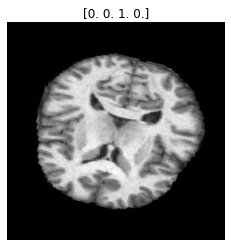

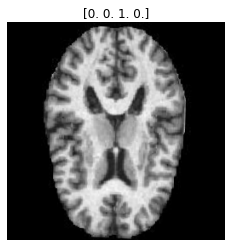

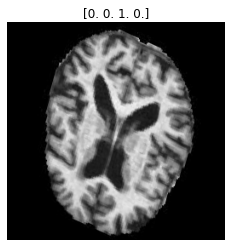

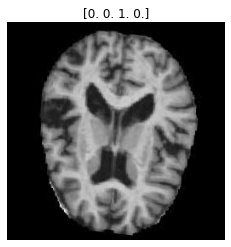

In [13]:
batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

## ANN

İlk yaklaşımımız ANN(Artificial Neural Networks) ile olacaktır.

Burada iki farklı model denedim birisi Dropout ile diğeri Dropoutsuz.

**Dropout**: Dropout katmanı, eğitim süresi boyunca her adımda bir hız sıklığıyla girdi birimlerini rastgele 0'a ayarlar, bu da overfitingi önlemeye yardımcı olur.

Son Dense bloğumuzdaki 4'e dikkat etmeliyiz. Buradaki sayı, sınıflandırma için kaç sınıf olduğunu belirtir.

loss fonksiyonunu CategoricalCrossentropy olarak belirledim.


In [24]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [256,256,3]),                             
keras.layers.Dense(300, activation = 'relu' ),

keras.layers.Dense(400, activation = 'relu' ),

keras.layers.Dense(400, activation = 'relu' ),

keras.layers.Dense(400, activation = 'relu' ),
keras.layers.Dense(4, activation = 'softmax')])

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=['acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True)
model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

Epoch 1/50
641/641 [==============================] - 59s 92ms/step - loss: 1.8239 - acc: 0.4730 - val_loss: 1.0360 - val_acc: 0.5004
Epoch 2/50
641/641 [==============================] - 60s 93ms/step - loss: 1.0487 - acc: 0.4993 - val_loss: 1.0344 - val_acc: 0.5004
Epoch 3/50
641/641 [==============================] - 60s 93ms/step - loss: 1.0390 - acc: 0.4999 - val_loss: 1.0359 - val_acc: 0.5004
Epoch 4/50
641/641 [==============================] - 60s 94ms/step - loss: 1.0628 - acc: 0.4997 - val_loss: 1.0392 - val_acc: 0.5004
Epoch 5/50
641/641 [==============================] - 60s 93ms/step - loss: 1.0519 - acc: 0.4999 - val_loss: 1.0370 - val_acc: 0.5004
Epoch 6/50
641/641 [==============================] - 60s 94ms/step - loss: 1.0393 - acc: 0.4999 - val_loss: 1.0336 - val_acc: 0.5004
Epoch 7/50
641/641 [==============================] - 60s 94ms/step - loss: 1.0895 - acc: 0.4991 - val_loss: 1.0442 - val_acc: 0.5004
Epoch 8/50
641/641 [==============================] - 60s 94ms

In [26]:
loss,accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

160/160 [==============================] - 2s 11ms/step - loss: 1.0335 - acc: 0.5004
Loss:  1.0335392951965332
Accuracy:  0.5003909468650818


Buradaki dropout değerleriyle oynanıp değişimlere bakılabilir.


In [27]:
#simple ann with 3 layers 
model = keras.models.Sequential([keras.layers.Flatten(input_shape = [256,256,3]),                             
keras.layers.Dense(300, activation = 'relu' ),
keras.layers.Dropout(0.2),
keras.layers.Dense(400, activation = 'relu' ),
keras.layers.Dropout(0.2),
keras.layers.Dense(400, activation = 'relu' ),
keras.layers.Dropout(0.2),
keras.layers.Dense(400, activation = 'relu' ),
keras.layers.Dense(4, activation = 'softmax')])


model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=['mae','acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_acc',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)
#save model
#data manipulation 
#include graphs 

Epoch 1/50
430/430 [==============================] - 4s 9ms/step - loss: 2.0892 - mae: 0.3098 - acc: 0.4678 - val_loss: 1.0351 - val_mae: 0.2990 - val_acc: 0.5024
Epoch 2/50
430/430 [==============================] - 4s 9ms/step - loss: 1.0417 - mae: 0.3040 - acc: 0.4990 - val_loss: 1.0316 - val_mae: 0.2960 - val_acc: 0.5024
Epoch 3/50
430/430 [==============================] - 4s 9ms/step - loss: 1.0420 - mae: 0.3043 - acc: 0.4999 - val_loss: 1.0304 - val_mae: 0.3092 - val_acc: 0.5024
Epoch 4/50
430/430 [==============================] - 4s 9ms/step - loss: 1.0395 - mae: 0.3048 - acc: 0.4999 - val_loss: 1.0293 - val_mae: 0.3021 - val_acc: 0.5024


In [14]:
loss,mae, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("mae: ", mae)
print("Accuracy: ", accuracy)

53/53 [==============================] - 0s 8ms/step - loss: 1.0351 - mae: 0.2990 - acc: 0.5024
Loss:  1.0351492166519165
mae:  0.2990034818649292
Accuracy:  0.5023809671401978


## CNN

In [21]:
#experiment with Convolutional neural net
model = keras.models.Sequential([
keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = [256,256,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(64, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(64, (2, 2), activation='relu'),
keras.layers.Flatten(),
keras.layers.Dense(100, activation='relu'),
keras.layers.Dense(4, activation ='softmax')])

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

In [22]:
model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)
#save model
#early stopping

Epoch 1/50
641/641 [==============================] - 62s 95ms/step - loss: 1.0491 - auc: 0.7929 - acc: 0.4950 - val_loss: 1.0533 - val_auc: 0.8146 - val_acc: 0.5043
Epoch 2/50
641/641 [==============================] - 60s 94ms/step - loss: 0.9566 - auc: 0.8238 - acc: 0.5419 - val_loss: 0.9623 - val_auc: 0.8238 - val_acc: 0.5324
Epoch 3/50
641/641 [==============================] - 60s 94ms/step - loss: 0.9261 - auc: 0.8348 - acc: 0.5532 - val_loss: 0.9703 - val_auc: 0.8294 - val_acc: 0.5496
Epoch 4/50
641/641 [==============================] - 59s 92ms/step - loss: 0.9054 - auc: 0.8404 - acc: 0.5606 - val_loss: 1.0400 - val_auc: 0.8255 - val_acc: 0.5106
Epoch 5/50
641/641 [==============================] - 60s 94ms/step - loss: 0.8910 - auc: 0.8466 - acc: 0.5710 - val_loss: 0.9547 - val_auc: 0.8213 - val_acc: 0.5317
Epoch 6/50
641/641 [==============================] - 61s 95ms/step - loss: 0.8806 - auc: 0.8494 - acc: 0.5796 - val_loss: 0.9198 - val_auc: 0.8378 - val_acc: 0.5598
Epoc

In [23]:
loss, auc, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

160/160 [==============================] - 2s 11ms/step - loss: 0.9089 - auc: 0.8479 - acc: 0.5770
Loss:  0.9089222550392151
AUC:  0.8478580117225647
Accuracy:  0.5770133137702942


In [ ]:
model = keras.models.Sequential([
keras.layers.Conv2D(224, (3, 3), activation='relu', input_shape = [256,256,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(448, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(448, (2, 2), activation='relu'),
keras.layers.Flatten(),
keras.layers.Dense(100, activation='relu'),
keras.layers.Dense(4, activation ='softmax')])

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_acc',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)
#save model
#early stopping

In [9]:
loss, auc, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", loss)
print("Accuracy: ", accuracy)

53/53 [==============================] - 2s 24ms/step - loss: 0.9479 - auc: 0.9272 - acc: 0.8048
Loss:  0.9479294419288635
AUC:  0.9479294419288635
Accuracy:  0.8047618865966797


## VGG19

In [3]:
vgg = VGG19(input_shape=(256,256,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [4]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])

callback = keras.callbacks.EarlyStopping(monitor='val_acc',
                                            patience=4,
                                            restore_best_weights=True)

In [5]:
modelvgg.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callback)

Epoch 1/50
430/430 [==============================] - 22s 43ms/step - loss: 1.0233 - auc: 0.8522 - acc: 0.5974 - val_loss: 0.7136 - val_auc: 0.9064 - val_acc: 0.6810
Epoch 2/50
430/430 [==============================] - 17s 40ms/step - loss: 0.6511 - auc: 0.9267 - acc: 0.7381 - val_loss: 0.9331 - val_auc: 0.8804 - val_acc: 0.6500
Epoch 3/50
430/430 [==============================] - 17s 40ms/step - loss: 0.5109 - auc: 0.9527 - acc: 0.7900 - val_loss: 0.8615 - val_auc: 0.8713 - val_acc: 0.6357
Epoch 4/50
430/430 [==============================] - 18s 42ms/step - loss: 0.4083 - auc: 0.9689 - acc: 0.8363 - val_loss: 0.6046 - val_auc: 0.9332 - val_acc: 0.7595
Epoch 5/50
430/430 [==============================] - 19s 43ms/step - loss: 0.3333 - auc: 0.9797 - acc: 0.8686 - val_loss: 0.5758 - val_auc: 0.9382 - val_acc: 0.7238
Epoch 6/50
430/430 [==============================] - 19s 45ms/step - loss: 0.3256 - auc: 0.9801 - acc: 0.8643 - val_loss: 0.5751 - val_auc: 0.9411 - val_acc: 0.7571
Epoc

In [7]:
loss, auc, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

53/53 [==============================] - 2s 37ms/step - loss: 0.4571 - auc: 0.9622 - acc: 0.8405
Loss:  0.45706629753112793
AUC:  0.9622363448143005
Accuracy:  0.8404762148857117
